## Overview of model

The model we'll start with is based on [Hastie and Lee](https://web.stanford.edu/~hastie/Papers/structmgm.pdf). It fits a certain type of 
*undirected* graphical model to a sample of random variables of mixed type (discrete or continuous).

It has the advantage that it also selects which *interactions* amongst the variables seem most relevant.

Our data is
$$
X = \begin{pmatrix} X_1 \\ X_2 \\ \vdots \\ X_n
\end{pmatrix}
$$
and each sample $X_i$ is of mixed type -- in `numpy / pandas` terms we can think of it having a `dtype` with some `np.float` fields as well as some `pandas.Categotical` fields.
We think of having $p$ different variables so we can talk about $X_{ij}, 1 \leq i \leq n, 1 \leq j \leq p$.

### Special case: binary random variables

In this case $X_i \in \{0,1\}^p$. The model here is a generalization of the Ising model. That is, each row is like a realization of an Ising model so we have a sample of realizations of Ising models.

The model is parameterized here by a $p \times p$ symmetric matrix $\Sigma$
and
$$
P_{\Theta}(X_i=x_i) \propto \exp\left(\sum_{j,k} x_{i,j} x_{i,k} \Theta_{jk} \right).
$$

Classical Ising models have a fixed graph, say with adjacency matrix $A$ and perhaps two parameters $(\theta_1, \theta_2)$: one for interaction and one affecting the overall mean (external field? not sure, not a physicist). In these models
$$
P_{(\theta_1, \theta_2)}(X_i=x) \propto \exp \left(\theta_1 \sum_j x_j + \theta_2 \sum_{j, k} x_j x_k A_{jk}\right)
$$
so we can think of this having a $\Theta$ with $\theta_1$ on the diagonal and $\theta_2/2$ off the diagonal.

This model therefore has a parameter for *each edge*. Edges are selected by putting a penalty on each edge, i.e. an $\ell_1$ penalty perhaps leaving the mean terms unpenalized:
$$
{\cal P}(\Theta) = \lambda \sum_{(j,k): j \neq k} |\Theta_{jk}|.
$$

### Psuedolikelihood

To fit this model is complicated -- it is expensive to normalize the $\propto$ in the likelihood so people, dating back to Besag in the 80s have used pseudolikelihood as the objective.

This objective is the sum of all the conditional likelihoods for one of the variables given all the others. E.g. in our Ising model here, if we *knew* $\Sigma$ then for any $X_{i,j}$ we know that $X_{i,j}$ is Bernoulli and given $X_{i,k}, k \neq j$ we can work out the probability it is 1 or 0 based on $\Sigma$. This is effectively the likelihood for a logistic regression. There is therefore a likelihood for each column $j$
$$
\ell_j(\Theta; X[:,j] | X[:,k], k \neq j)
$$
and the pseudo-likelihood (sum of conditional negative log-likelihoods) is
$$
\Theta \mapsto \sum_{j=1}^p \ell_j(\Theta; X[:,j] | X[:,k], k \neq j).
$$

The penalized *pseudolikelihood* is 
$$
\Theta \mapsto \left[\sum_{j=1}^p \ell_j(\Theta; X[:,j] | X[:,k], k \neq j)\right] + {\cal P}(\Theta).
$$

This is an objective we can minimize as a function of $\Theta$. For large enough values of $\lambda$ the minimize, $\Theta$ will be sparse off-diagonal. This is the *undirected* graph selection.

### Special case: all continuous

When each feature is continuous, a common model for the distribution
would be Gaussian. This can be parameterized in terms of sufficient
statistics $X$ and $XX^T$ with natural parameters $\alpha$ and
$\Theta$, say. So, the density can be written as $$
P_{\alpha,\Theta}(X_i=x) \propto \exp \left(\alpha^Tx +
\text{Tr}(\Theta xx^T) \right).$$ 
This is of course the normal
family but parametrized slightly differently.

This is quite similar to the binary case (in the binary case we could
suck the $\alpha$ into the diagonal of $\Theta$) but this doesn't work in the Gaussian case.

In this case, for one of the columns $X[:,j]$ there is a
pseudo-likelihood corresponding to predicting $X[:,j]$ as a function
of $X[:,k], k \neq j$. Each term in the this pseudo-likelihood looks
like a linear regression loss function. Summing these terms gives a
pseudo-likelihood that could be used to fit the *graphical LASSO*
(e.g. `glasso` in `R`).

For Gaussians we need to introduce a separate scale parameter in the optimization.
Call these $\alpha$. Enforcing each $\Theta[j,j]$ block to be 0, our $j$-th pseudolikelihood
for a Gaussian is a normalized version of the density
$$
x_j \mapsto \exp\left(x_j \cdot \left(\sum_{k:k \neq j} \Theta[k,j] x_k\right) - \alpha_j x_j^2 \right). 
$$
The normalizing constant is
$$
\sqrt{2 \pi /\alpha_j} \exp\left( \frac{1}{2 \alpha_j} (\Theta[j]^Tx)^2 \right)
$$
so the likelihood for a continuous feature is
$$
(\Theta[j], \alpha_j) \mapsto \frac{1}{\sqrt{2\pi/\alpha_j}} \exp\left(-\frac{\alpha_j}{2} (\Theta[j]x - x_j)^2 \right)
$$
where we have used the convention that $\Theta[j,j]=0$.

Taking negative logs yields
$$
(\Theta[j], \alpha_j) \mapsto - \frac{1}{2}\log(\alpha_j) + \frac{\alpha_j}{2}(\Theta[j]x-x_j)^2
$$

Stacking rows and summing yields
$$
(\Theta[j], \alpha_j) \mapsto - \frac{n}{2}\log(\alpha_j) + \frac{\alpha_j}{2}\|\eta_j-X[:,j]\|^2_2
$$
with $\eta_j = X\Theta[:,j]$.            

In fact, fixing $\Theta$, we could solve for $\alpha_j$ but this seems messy.

### Putting these together

It is now not hard to see how to mix continuous and binary. Each binary `field` has a reference sample space of $\{0,1\}$ while each continuous one has a reference sample space $\mathbb{R}$. Stringing all fields together gives a sample space
$$
\{0,1\}^{j:j \in {\cal B}} \times \mathbb{R}^{j: j \in {\cal C}}
$$
where ${\cal B}$ are the binary fields in our `dtype` and ${\cal C}$ are the floating type fields in our `dtype`. If we had categorical instead of binary then that field's $\{0,1\}$ would be replaced by $\{1, \dots, N_j\}$ where $N_j$ is the number of categories for field $j$.

We now have a symmetric $p \times p$ *matrix* $\Theta$ (it's not really a matrix) where each entry $\Theta_{jk}$ models the interaction between field $j$ and field $k$ of the `dtype`. When $j$ or $k$ is categorical (including binary) the entry $\Theta_{jk}$ is really a matrix. Concretely, suppose $N_j=3$ and $N_k=5$ then, if we were to fit a 
multinomial regression (the analog of logistic for categorical) of $X[:,j]$ on to $X[:,k]$ then there would be a $3 \times 5$ matrix of parameters in that model. (Note that much software often will set some of these to 0 automatically for identification reasons -- in this model with the penalty it is common not to do this). Anyways, we see that $\Theta_{jk}$ is really in $\mathbb{R}^{3 \times 5}$ and $\Theta_{kj} = \Theta_{jk}^T \in \mathbb{R}^{5 \times 3}$.

The (or, an) analog of the $\ell_1$ penalty for the *matrix* $\Theta_{jk}$ is the Frobenius norm -- this is what the authors propose.

### Relation to separate regressions

In order to understand the relationships between columns it is tempting to simply regress each $X[:,j]$ onto all the other columns. The total objective in this case would be a sum of negative log-likelihoods and would look a lot like our pseudo-likelihood. The difference is that the pseudo-likelihood assumes symmetry and ties the parameters together this way. The separate regression framework drops this requirement.

That is, the total loss for separate regressions is the same as the pseudo-likelihood
but the pseudo-likelihood has linear constraints enforcing symmetry of the $\Theta$ "matrix".


### Fitting the model

The model can be fit by proximal gradient methods, so we really just have to compute the
objective (as a function of $\Theta$ with $X$ fixed) and its gradient.

As each term in the pseudo-likelihood is like a regression (negative log-) likelihood it is enough to have appropriate regression losses for each node.

The proximal step is essentially the group LASSO proximal step (though here the parameters are matrices rather than vectors). By appropriate `vec` operations we should be able to use a group LASSO map.

### TODO

0. Create a *design matrix* `X` and a dict mapping fields of the dtype to columns. Should include a column of 1s. Continuous features enter as columns unchanged. Categorical features are coded using *full* representation, i.e. for a categorical with $N_j$ levels we want $N_j$ 1-hot columns in the design matrix. Our final $\Theta$ parameter will have shape $(X.shape[1], X.shape[1])$ and will be symmetric but we will store as regular `ndarray`.

1. Create a representation of the pseudo-likelihood that can compute
the maps
$$
\begin{aligned}
\Theta & \mapsto \sum_{j=1}^p \ell_j\left(\Theta; X[:,j] | X[:,k], k \neq j \right) \\
\Theta & \mapsto \nabla_{\Theta} \sum_{j=1}^p \ell_j\left(\Theta; X[:,j] | X[:,k], k \neq j \right)
\end{aligned}
$$
Note that $\ell_j$ depends only on $\Theta[j]$ and differentiating with respect to
a term like $\Theta[j,k]$ will involve only the losses $\ell_k$ and $\ell_j$.

2. Make a group LASSO penalty for the $\Theta$ matrix that sets $\infty$ penalty on the "diagonal" terms $\Theta[j,j]$.

3. We should be able to just write the loss as a sum of saturated losses for each *response* composed with `X.dot(Theta[j])`, i.e.

     loss(theta) = sum([s_loss(X.dot(Theta[j])) for s_loss in saturated_losses])

4. For a categorical variable with $N_j$ levels `X.dot(Theta[j])` should have shape `(n, N_j)` and this product should effectively zero out any *self* terms in the sum over the
$\sum_j N_j$ in the matrix product. I.e. I am imaging that feature $j$ has been allocated $N_j$ columns in $X$ (the usual 1-hot encoding of multinomials).

5. If we can write out the objective with a single `X` matrix, then I think the $\Theta[j,k]$ gradient will simply look at the `k` rows of the `j` loss plus the `j` rows of the `k` loss.

### Toy example

Let's make a data frame with 7 features, 2 binary, 2 categorical and 3 continuous. We'll code the binary as multinomial.

In [1]:
import numpy as np, pandas as pd
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline


D = pd.read_csv('atl06.csv') # .iloc[:5000]
D = D.dropna()
del(D['Unnamed: 0'])
D.columns, D.shape

(Index(['ground_track', 'lat', 'lon', 'h_li', 's_li', 'q_flag', 's_fg', 'snr',
        'h_rb', 'dh_fit_dx', 'b_snow_conf', 'c_flg_asr', 'c_flg_atm', 'msw',
        'bsnow_h', 'bsnow_od', 'layer_flag', 'bckgrd', 'e_bckgrd',
        'n_fit_photons', 'segment_id', 'w_surface_window_final'],
       dtype='object'),
 (252416, 22))

In [2]:
def make_onehot(categorical_col):  #TODO: would be more robust to know labels beforehand
                                   # e.g. for cross-validation
    labels = sorted(np.unique(categorical_col))
    return np.equal.outer(np.asarray(categorical_col), labels)

def make_design(df, desc):
    design = [np.ones((df.shape[0], 1))] # column for intercept
    new_desc = [('intercept', None, slice(0, 1))]
    idx = 1
    for col, dtype in desc:
        if dtype in ['binary', 'categorical']:
            design_col = make_onehot(df[col])
            ncol = design_col.shape[1]
            design.append(design_col)
            new_desc.append((col, dtype, slice(idx, idx + ncol)))
            idx += ncol
        elif dtype == 'continuous': # a continuous one
            new_desc.append((col, dtype, slice(idx, idx+1)))
            design_col = np.asarray(df[col].copy())
            # should we standardize?
            design_col.shape = (-1,1)
            design.append(design_col)
            idx += 1
    return np.hstack(design), new_desc

desc = [('s_li', 'continuous'),
        ('q_flag', 'binary'),
        ('snr', 'continuous'),
        ('h_rb', 'continuous'),
        ('dh_fit_dx', 'continuous'),
        ('b_snow_conf', 'categorical'),
        ('c_flg_asr', 'categorical'),
        ('c_flg_atm', 'categorical'),
        ('msw', 'categorical' ),
        #('bsnow_h', 'continuous'),
        #('bsnow_od', 'continuous'),
        ('layer_flag', 'binary'),
        ('bckgrd', 'continuous'),
        ('e_bckgrd', 'continuous'),
        ('n_fit_photons', 'continuous'),
        ('w_surface_window_final', 'continuous')]
desc
(np.mean(D['bsnow_od'] == D['bsnow_od'].max()), 
 np.mean(D['bsnow_h'] == D['bsnow_h'].max()))
np.percentile(D['w_surface_window_final'], [2,98])

array([3.       , 4.4581361])

In [3]:
X, desc2 = make_design(D, desc)
#X = X[np.random.choice(np.arange(X.shape[0]), 50000, replace=False)]
desc2
np.unique(D['snr']), np.unique(D['h_rb'])

(array([0.0000000e+00, 6.7144660e-09, 1.0892861e-08, ..., 9.3741010e-01,
        9.3925035e-01, 9.4173110e-01]),
 array([3.4386003e-03, 5.2483900e-03, 5.4293690e-03, ..., 4.9964676e+00,
        5.0000000e+00, 3.4028235e+38]))

In [4]:
[(len(np.unique(D[c])), t) for c, t, _ in desc2[1:]]

[(246767, 'continuous'),
 (2, 'binary'),
 (6299, 'continuous'),
 (7268, 'continuous'),
 (175317, 'continuous'),
 (8, 'categorical'),
 (6, 'categorical'),
 (3, 'categorical'),
 (4, 'categorical'),
 (2, 'binary'),
 (243085, 'continuous'),
 (243308, 'continuous'),
 (713, 'continuous'),
 (3216, 'continuous')]

### Form saturated losses 

This will use the `regreg` package: `http://github.com/jonathan-taylor/regreg.git`

For `binary` or `categorical` we will use multinomial loss, while for `continuous`
we will use the special Gaussian loss described above.

In [5]:
from regreg.smooth.mglm import multinomial_loglike
from regreg.smooth.glm import gaussian_loglike
import regreg.api as rr        

In [6]:
np.isnan(X[:,4]).sum(), X.std(0), X[:,0][:10]

(0,
 array([0.00000000e+00, 4.27455210e+37, 1.48234511e-01, 1.48234511e-01,
        5.01065967e-02, 2.71481633e+37, 3.24797455e+37, 1.17049969e-01,
        4.79491936e-01, 4.99880513e-01, 1.29609944e-01, 2.40016662e-01,
        2.18420378e-01, 9.24887027e-02, 3.79471257e-02, 3.87709290e-02,
        4.64835303e-01, 4.99214417e-01, 3.29700907e-01, 1.41454415e-01,
        2.48590316e-01, 4.57907820e-01, 4.53777379e-01, 9.53066884e-02,
        4.89373218e-01, 2.95966657e-01, 3.68165670e-01, 3.45703179e-01,
        2.77489125e-01, 2.77489125e-01, 4.27455210e+37, 4.27455210e+37,
        1.57090474e+08, 3.24797455e+37]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

### Combine losses into a smooth objective function

In [7]:
def _reshape(G):
    if G.ndim == 1:
        return G.reshape((-1, 1))
    return G

class gaussian_loss(rr.smooth_atom):

    """
    This codes up (11) of Lee and Hastie
    """

class full_loss(rr.smooth_atom):
    
    def __init__(self,
                 X,
                 desc,
                 symmetrize=True,
                 coef=1.,
                 offset=None,
                 quadratic=None,
                 case_weights=None,
                 initial=None):
        
        (self.X, 
         self.symmetrize) = (X.copy(), symmetrize)

        # create individual losses
        # categorical / binary
        # are multinomial

        # continuous ones get a special loss
        # with unknown covariance
        
        idx_cont = 0
        self.desc = []
        self.sum_sq = []
        for var, dtype, idx in desc:
            if dtype in ['binary', 'categorical']:
                response = self.X[:,idx]
                self.desc.append((var, dtype, idx,
                                  multinomial_loglike(response.shape,
                                                      response), 
                                  None))
            elif dtype == 'continuous':
                response = np.squeeze(self.X[:,idx]) # it will be a 2D array
                if var not in ['snr', 'w_surface_window_final', 'intercept']:
                    l, u = np.percentile(response, [5, 95]) # quick and dirty cleaning..
                    response = np.clip(response, l, u)
                elif var == 'w_surface_window_final':
                    l, u = np.percentile(response, [2, 98]) # quick and dirty cleaning..
                    response = np.clip(response, l, u)
                response -= np.mean(response)
                response /= np.std(response)
                self.X[:,idx] = response[:,None]
                self.sum_sq.append((response**2).sum())
                self.desc.append((var, dtype, idx,
                                  gaussian_loglike(response.shape,
                                                   response),
                                  idx_cont))
                idx_cont += 1
            else:
                self.desc.append((var, dtype, idx, None, None))

        rr.smooth_atom.__init__(self,
                                shape=(X.shape[1]**2 + idx_cont),
                                coef=coef,
                                offset=offset,
                                quadratic=quadratic,
                                initial=initial)
        
        self.matrix_slice = slice(0, X.shape[1]**2, None)
        self.scale_slice = slice(X.shape[1]**2, X.shape[1]**2 + idx_cont, None)
        self.sum_sq = np.array(self.sum_sq)
        self._grad_buff = np.zeros((X.shape[1], 
                                    X.shape[1]))
        
    def smooth_objective(self, arg, mode='both', check_feasibility=False):
        
        arg = self.apply_offset(arg)
        matrix_arg = arg[self.matrix_slice].reshape((self._grad_buff.shape))
        scale_arg = arg[self.scale_slice]
        scale_arg = np.maximum(scale_arg, 1.e-14)
        scale_grad = np.zeros_like(scale_arg)
        full_grad = np.zeros(self.shape)
        eta = natural_param = self.X.dot(matrix_arg) # same shape as X
        nobs = eta.shape[0]
        # because we will force
        # diagonal blocks to have np.inf
        # weight, these parameters will be zero
        # so column j of eta above is really only summing over k != j
        _f = []
        _g = []
        for _, _, _slice, _loss, _scale_idx in self.desc:
            if _loss is not None:
                if _scale_idx is not None: # continuous variable
                    _scale = scale_arg[_scale_idx]
                    _eta = np.squeeze(eta[:,_slice])
                    _fval, _gval = _loss.smooth_objective(_eta / 
                                                          _scale, 'both')
                    scale_grad[_scale_idx] = 0.5 * ((- nobs / _scale) + 
                                                        self.sum_sq[_scale_idx] -
                                                        1. / _scale**2 * (_eta**2).sum())
                    _fval *= _scale
                    _fval += -nobs * 0.5 * np.log(_scale)
                else:
                    _fval, _gval = _loss.smooth_objective(eta[:,_slice], 
                                                          'both')
                _f.append(_fval)
                _g.append(_reshape(_gval))
        
        if mode == 'func':
            return self.scale(np.sum(_f))
        elif mode == 'grad':
            self._grad_buff[:,1:] = self.scale(self.X.T.dot(np.hstack(_g)))
            self._grad_buff[:,0] = 0
            if self.symmetrize:
                self._grad_buff = 0.5 * (self._grad_buff + self._grad_buff.T)
            full_grad[self.matrix_slice] = self._grad_buff.reshape(-1)
            full_grad[self.scale_slice] = self.scale(scale_grad)
            return full_grad
        elif mode == 'both':
            self._grad_buff[:,1:] = self.scale(self.X.T.dot(np.hstack(_g)))
            self._grad_buff[:,0] = 0
            if self.symmetrize:
                self._grad_buff = 0.5 * (self._grad_buff + self._grad_buff.T)
            full_grad[self.matrix_slice] = self._grad_buff.reshape(-1)
            full_grad[self.scale_slice] = self.scale(scale_grad)
            return self.scale(np.sum(_f)), full_grad

In [8]:
loss = full_loss(X, desc2)
F, G = loss.smooth_objective(np.zeros(loss.shape), 'both')
G.shape
X.std(0), loss.shape

/Users/jonathantaylor/Stanford/projects/CloudMask/other/regreg/regreg/smooth/mglm.py:787: RuntimeWarning: divide by zero encountered in log
  loss_terms = np.log(saturated) * self.counts
/Users/jonathantaylor/Stanford/projects/CloudMask/other/regreg/regreg/smooth/mglm.py:787: RuntimeWarning: invalid value encountered in multiply
  loss_terms = np.log(saturated) * self.counts


(array([0.00000000e+00, 4.27455210e+37, 1.48234511e-01, 1.48234511e-01,
        5.01065967e-02, 2.71481633e+37, 3.24797455e+37, 1.17049969e-01,
        4.79491936e-01, 4.99880513e-01, 1.29609944e-01, 2.40016662e-01,
        2.18420378e-01, 9.24887027e-02, 3.79471257e-02, 3.87709290e-02,
        4.64835303e-01, 4.99214417e-01, 3.29700907e-01, 1.41454415e-01,
        2.48590316e-01, 4.57907820e-01, 4.53777379e-01, 9.53066884e-02,
        4.89373218e-01, 2.95966657e-01, 3.68165670e-01, 3.45703179e-01,
        2.77489125e-01, 2.77489125e-01, 4.27455210e+37, 4.27455210e+37,
        1.57090474e+08, 3.24797455e+37]),
 (1164,))

### Construct penalty

The basic penalty is a group lasso for every "block" $\Theta[k,j]$. We've flattened
$\Theta$ above so we can just use the usual group LASSO penalty.

The penality is
$$
{\cal P}(\Theta) = \lambda \sum_{(j,k): j < k} w_{(j,k)} \|\Theta[j,k]\|_F
$$
where
$$
\|A\|_F = Tr(A^TA)^{1/2} = \left(\sum_{i,j} A_{ij}^2 \right)^{1/2}
$$

In [9]:
R, C = np.zeros((2, X.shape[1], X.shape[1]), np.int)
var_names = list(D.columns) + ['intercept']

for l, r in product(desc2, desc2):
    l_slice = l[2]
    r_slice = r[2]
    R[l_slice][:,r_slice] = R[r_slice][:,l_slice] = var_names.index(r[0])
    C[l_slice][:,r_slice] = C[r_slice][:,l_slice] = var_names.index(l[0])  
I = np.transpose(np.array([R, C]), [1, 2, 0])
I.shape

(34, 34, 2)

In [10]:
B2_slice, M1_slice = desc2[1][2], desc2[2][2]
B2_slice, M1_slice

(slice(1, 2, None), slice(2, 4, None))

In [11]:
I[B2_slice][:,M1_slice][:,:,0], I[M1_slice][:,B2_slice][:,:,0]

(array([[4, 4]]),
 array([[4],
        [4]]))

In [12]:
I[B2_slice][:,M1_slice][:,:,1], I[M1_slice][:,B2_slice][:,:,1]

(array([[5, 5]]),
 array([[5],
        [5]]))

In [13]:
groups = ['-'.join(sorted([var_names[r], var_names[c]])) for r, c in zip(R.reshape(-1), C.reshape(-1))]
len(groups), groups[:40]

(1156,
 ['intercept-intercept',
  'intercept-s_li',
  'intercept-q_flag',
  'intercept-q_flag',
  'intercept-snr',
  'h_rb-intercept',
  'dh_fit_dx-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'b_snow_conf-intercept',
  'c_flg_asr-intercept',
  'c_flg_asr-intercept',
  'c_flg_asr-intercept',
  'c_flg_asr-intercept',
  'c_flg_asr-intercept',
  'c_flg_asr-intercept',
  'c_flg_atm-intercept',
  'c_flg_atm-intercept',
  'c_flg_atm-intercept',
  'intercept-msw',
  'intercept-msw',
  'intercept-msw',
  'intercept-msw',
  'intercept-layer_flag',
  'intercept-layer_flag',
  'bckgrd-intercept',
  'e_bckgrd-intercept',
  'intercept-n_fit_photons',
  'intercept-w_surface_window_final',
  'intercept-s_li',
  's_li-s_li',
  'q_flag-s_li',
  'q_flag-s_li',
  's_li-snr',
  'h_rb-s_li'])

In [14]:
weights = {}
covs = {}
for d in desc2:
    X_ = X[:,d[2]] * 1.
    X_ = X_ - X_.mean(0)
    C_ = X_.T.dot(X_) / X_.shape[0]
    covs[d[0]] = np.diag(C_).sum()
    
for l, r in product(covs.keys(), covs.keys()):
    weights['-'.join(sorted([l, r]))] = np.sqrt(covs[l] * covs[r])
    if l == r:
        weights['-'.join([l, r])] = np.inf
for d in loss.desc:
    if d[1] == 'continuous':
        weights[d[0]+'-scale'] = 0
        groups.append(d[0]+'-scale')
weights

{'intercept-intercept': inf,
 'intercept-s_li': 0.0,
 'intercept-q_flag': 0.0,
 'intercept-snr': 0.0,
 'h_rb-intercept': 0.0,
 'dh_fit_dx-intercept': 0.0,
 'b_snow_conf-intercept': 0.0,
 'c_flg_asr-intercept': 0.0,
 'c_flg_atm-intercept': 0.0,
 'intercept-msw': 0.0,
 'intercept-layer_flag': 0.0,
 'bckgrd-intercept': 0.0,
 'e_bckgrd-intercept': 0.0,
 'intercept-n_fit_photons': 0.0,
 'intercept-w_surface_window_final': 0.0,
 's_li-s_li': inf,
 'q_flag-s_li': 8.960968254112539e+36,
 's_li-snr': 2.1418325834683843e+36,
 'h_rb-s_li': 1.1604623865936536e+75,
 'dh_fit_dx-s_li': 1.3883636455770038e+75,
 'b_snow_conf-s_li': 3.3809574676806117e+37,
 'c_flg_asr-s_li': 3.465550148909536e+37,
 'c_flg_atm-s_li': 2.785607393439636e+37,
 'msw-s_li': 3.261399380603476e+37,
 'layer_flag-s_li': 1.6774577114560335e+37,
 'bckgrd-s_li': 1.8271795682356935e+75,
 'e_bckgrd-s_li': 1.8271795682356935e+75,
 'n_fit_photons-s_li': 6.714914151075733e+45,
 's_li-w_surface_window_final': 1.3883636455770038e+75,
 'q_f

In [15]:
penalty = rr.group_lasso(list(groups), weights=weights, lagrange=10 * np.sqrt(X.shape[0]))
penalty.shape

(1164,)

In [16]:
problem = rr.simple_problem(loss, penalty)


In [17]:
loss.smooth_objective(problem.coefs, 'grad')
X[:,0][:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
problem.coefs[:] = 0
problem.coefs[-8:] = 1.

In [19]:
soln = problem.solve(start_step=1/X.shape[0], min_its=50, debug=True)

0    obj: 2.963970e+06    step: 3.96e-06    rel_obj_change: 2.66e-01    tol: 1.0e-05
1    obj: 2.175321e+06    step: 3.96e-06    rel_obj_change: 5.45e-02    tol: 1.0e-05
2    Decreasing step to 3.601558178130186e-06
2    Decreasing step to 3.274143798300169e-06
2    Decreasing step to 2.9764943620910623e-06
2    obj: 2.056875e+06    step: 2.98e-06    rel_obj_change: 3.63e-02    tol: 1.0e-05
3    Decreasing step to 2.705903965537329e-06
3    Decreasing step to 2.4599126959430263e-06
3    obj: 1.982153e+06    step: 2.46e-06    rel_obj_change: 2.94e-02    tol: 1.0e-05
4    obj: 1.923835e+06    step: 2.46e-06    rel_obj_change: 2.43e-02    tol: 1.0e-05
5    obj: 1.877017e+06    step: 2.46e-06    rel_obj_change: 2.11e-02    tol: 1.0e-05
6    obj: 1.837412e+06    step: 2.46e-06    rel_obj_change: 1.90e-02    tol: 1.0e-05
7    obj: 1.802490e+06    step: 2.46e-06    rel_obj_change: 1.72e-02    tol: 1.0e-05
8    obj: 1.771536e+06    step: 2.46e-06    rel_obj_change: 1.55e-02    tol: 1.0e-05
9  

93    obj: 1.524593e+06    step: 2.46e-06    rel_obj_change: 5.17e-05    tol: 1.0e-05
94    obj: 1.524514e+06    step: 2.46e-06    rel_obj_change: 5.05e-05    tol: 1.0e-05
95    obj: 1.524437e+06    step: 2.46e-06    rel_obj_change: 4.92e-05    tol: 1.0e-05
96    obj: 1.524362e+06    step: 2.46e-06    rel_obj_change: 4.79e-05    tol: 1.0e-05
97    obj: 1.524289e+06    step: 2.46e-06    rel_obj_change: 4.66e-05    tol: 1.0e-05
98    obj: 1.524218e+06    step: 2.46e-06    rel_obj_change: 4.53e-05    tol: 1.0e-05
99    obj: 1.524149e+06    step: 2.71e-06    rel_obj_change: 4.42e-05    tol: 1.0e-05
100    obj: 1.524082e+06    step: 2.98e-06    rel_obj_change: 4.33e-05    tol: 1.0e-05
101    obj: 1.524016e+06    step: 3.27e-06    rel_obj_change: 4.26e-05    tol: 1.0e-05
102    obj: 1.523951e+06    step: 3.60e-06    rel_obj_change: 4.22e-05    tol: 1.0e-05
103    obj: 1.523886e+06    step: 3.96e-06    rel_obj_change: 4.21e-05    tol: 1.0e-05
104    obj: 1.523822e+06    step: 4.36e-06    rel_

In [20]:
loss.smooth_objective(problem.coefs, 'grad')
problem.coefs[-8:]

array([1.        , 1.47856496, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [21]:
loss.sum_sq

array([252416., 252416., 252416., 252416., 252416., 252416., 252416.,
       252416.])

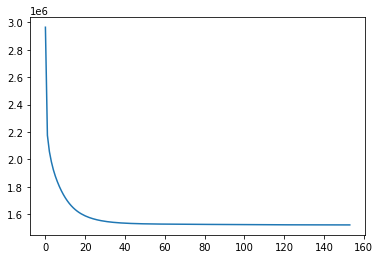

In [22]:
problem.coefs[loss.matrix_slice].reshape((X.shape[1], X.shape[1]))[0]
plt.plot(problem.solver_results)

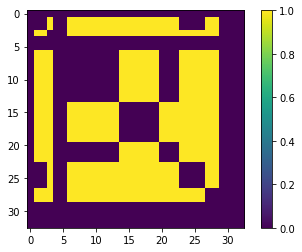

In [23]:
matrix_soln = problem.coefs[loss.matrix_slice].reshape((X.shape[1], X.shape[1]))
matrix_soln = matrix_soln[1:][:,1:]
plt.imshow(matrix_soln != 0)
matrix_soln = np.sign(matrix_soln) * np.log(np.fabs(matrix_soln)+1)
plt.colorbar()

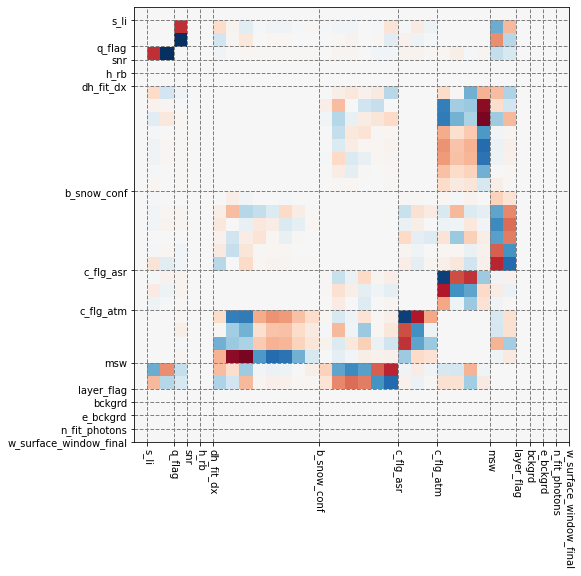

In [24]:
f = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.imshow(matrix_soln, cmap='RdBu', interpolation='nearest', vmin=-np.fabs(matrix_soln).max(),
         vmax=np.fabs(matrix_soln).max())
ylim, xlim = ax.get_ylim(), ax.get_xlim()
ax.xaxis.set_ticks(np.cumsum([X[:,d[2]].shape[1] for d in desc2[1:]]) - 0.5)
ax.yaxis.set_ticks(np.cumsum([X[:,d[2]].shape[1] for d in desc2[1:]]) - 0.5)
ax.set_xticklabels([d[0] for d in desc2[1:]], rotation=270)
ax.set_yticklabels([d[0] for d in desc2[1:]])
ax.grid(color='gray', linewidth=1, linestyle='--')
f

-1.4497660954439562

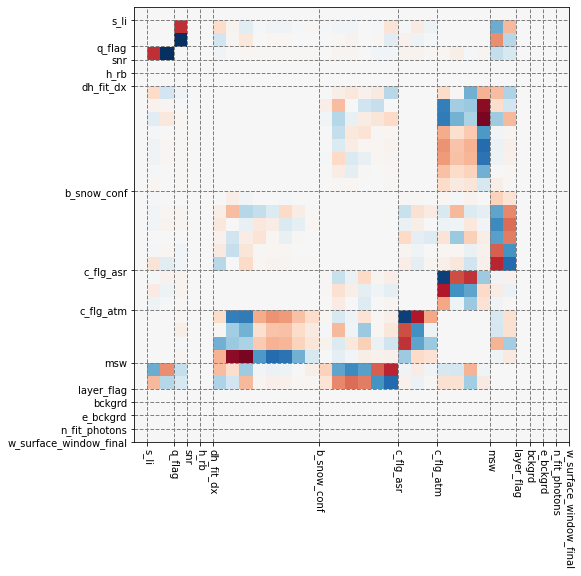

In [25]:
matrix_soln.min()

In [26]:
group_keys = sorted(weights.keys())
group_img = np.array([group_keys.index(g) for g in groups])[loss.matrix_slice].reshape((X.shape[1], X.shape[1]))

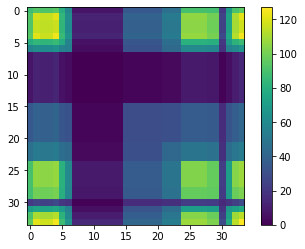

In [27]:
plt.imshow(group_img)
plt.colorbar()

In [28]:
np.unique(group_img).shape

(120,)

In [29]:
len(group_keys)

128

## Regular markdown

In [30]:
from regreg.sklearn.base import sklearn_regression

class sklearn_mixed(sklearn_regression):

    """

    A simple regression mixin for sklearn
    that allows any atom to be used as a regularizer.

    """

    def __init__(self, 
                 atom_constructor, 
                 atom_params, 
                 desc,
                 case_weights=False,
                 offset=False,
                 coef=1., 
                 quadratic=None,
                 score_method='deviance',
                 solve_args={},
                 initial=None):
        
        self.desc = desc
        self.initial = initial
        sklearn_regression.__init__(self,
                                    atom_constructor,
                                    atom_params,
                                    case_weights=case_weights,
                                    offset=offset,
                                    coef=coef,
                                    score_method=score_method,
                                    solve_args=solve_args,
                                    initial=initial)
        self.solve_args = solve_args
        
    def _loglike_factory(self, X, y):
        loss = full_loss(X, self.desc)
        return loss

    def _saturated_score(self,
                         predictions,
                         response,
                         case_weights=None):

        # XXX fix these scores!!!
        if self.score_method == 'deviance':
            return np.random.standard_normal()
        elif self.score_method == 'mean_deviance':
            return np.random.standard_normal()
        elif self.score_method == 'R2':
            SSE = np.sum(loss(predictions))
            SST = np.sum(loss(response.mean() * np.ones_like(response)))
            return np.mean(loss(predictions))
        else:
            return np.nan
        
    def score(self, X, y, sample_weight=None):
        '''
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Test samples.

        y : array-like, shape = (n_samples) or (n_samples, n_outputs)
            True values for X.

        sample_weight : array-like, shape = [n_samples], optional
            Sample weights.

        Returns
        -------
        score : float
        '''
        return np.random.standard_normal() ### fix this!!!
        predictions = X.dot(self._coefs)
        if offset is not None:
            predictions -= offset   # this is how offsets are incorporated
                                    # in regreg
        if sample_weight is not None:
            if case_weights is not None:
                case_weights *= sample_weight
        return self._saturated_score(predictions, response, case_weights=case_weights)

In [31]:
from sklearn.model_selection import cross_validate
sklearn_loss = sklearn_mixed(rr.group_lasso,
                             {'groups':groups,
                              'weights':weights,
                              'lagrange':10 * np.sqrt(X.shape[0])},
                             desc2,
                             solve_args={'start_step':1/X.shape[0], 'debug':True},                             
                             initial=problem.coefs.copy())                                    

sklearn_loss.fit(X, None)

/Users/jonathantaylor/Stanford/projects/CloudMask/other/regreg/regreg/smooth/mglm.py:787: RuntimeWarning: divide by zero encountered in log
  loss_terms = np.log(saturated) * self.counts
/Users/jonathantaylor/Stanford/projects/CloudMask/other/regreg/regreg/smooth/mglm.py:787: RuntimeWarning: invalid value encountered in multiply
  loss_terms = np.log(saturated) * self.counts


0    obj: 1.521899e+06    step: 3.96e-06    rel_obj_change: 1.45e-06    tol: 1.0e-05
1    obj: 1.521897e+06    step: 3.96e-06    rel_obj_change: 1.42e-06    tol: 1.0e-05
2    obj: 1.521894e+06    step: 3.96e-06    rel_obj_change: 1.80e-06    tol: 1.0e-05
3    obj: 1.521892e+06    step: 3.96e-06    rel_obj_change: 2.14e-06    tol: 1.0e-05
4    obj: 1.521888e+06    step: 3.96e-06    rel_obj_change: 2.46e-06    tol: 1.0e-05
5    obj: 1.521885e+06    step: 3.96e-06    rel_obj_change: 2.75e-06    tol: 1.0e-05
Success: Optimization stopped because decrease in objective was below tolerance
FISTA used 5 of 10000 iterations


/Users/jonathantaylor/opt/anaconda3/envs/icesat2/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


sklearn_mixed(atom_constructor=<class 'regreg.atoms.group_lasso.group_lasso'>,
              atom_params={'groups': ['intercept-intercept', 'intercept-s_li',
                                      'intercept-q_flag', 'intercept-q_flag',
                                      'intercept-snr', 'h_rb-intercept',
                                      'dh_fit_dx-intercept',
                                      'b_snow_conf-intercept',
                                      'b_snow_conf-intercept',
                                      'b_snow_conf-intercept',
                                      'b_snow_conf-intercept',
                                      'b_snow_conf-intercept...
                    ('bckgrd', 'continuous', slice(30, 31, None)),
                    ('e_bckgrd', 'continuous', slice(31, 32, None)),
                    ('n_fit_photons', 'continuous', slice(32, 33, None)),
                    ('w_surface_window_final', 'continuous',
                     slice(33, 34, None))],

In [34]:
cross_validate(sklearn_loss, X, np.ones(X.shape[0]), cv=3)

<ipython-input-7-919b2bf20307>:53: RuntimeWarning: invalid value encountered in true_divide
  response /= np.std(response)


0    obj: 1.070396e+06    step: 3.96e-06    rel_obj_change: 7.51e-03    tol: 1.0e-05
1    obj: 1.062360e+06    step: 3.96e-06    rel_obj_change: 2.72e-03    tol: 1.0e-05
2    obj: 1.059466e+06    step: 3.96e-06    rel_obj_change: 1.91e-03    tol: 1.0e-05
3    obj: 1.057444e+06    step: 3.96e-06    rel_obj_change: 1.54e-03    tol: 1.0e-05
4    obj: 1.055814e+06    step: 3.96e-06    rel_obj_change: 1.31e-03    tol: 1.0e-05
5    obj: 1.054426e+06    step: 3.96e-06    rel_obj_change: 1.12e-03    tol: 1.0e-05
6    obj: 1.053240e+06    step: 3.96e-06    rel_obj_change: 9.60e-04    tol: 1.0e-05
7    obj: 1.052228e+06    step: 3.96e-06    rel_obj_change: 8.18e-04    tol: 1.0e-05
8    obj: 1.051367e+06    step: 3.96e-06    rel_obj_change: 6.93e-04    tol: 1.0e-05
9    obj: 1.050639e+06    step: 3.96e-06    rel_obj_change: 5.83e-04    tol: 1.0e-05
10    obj: 1.050027e+06    step: 3.96e-06    rel_obj_change: 4.89e-04    tol: 1.0e-05
11    obj: 1.049513e+06    step: 3.96e-06    rel_obj_change: 4.1

26    obj: 9.877198e+05    step: 3.96e-06    rel_obj_change: 2.86e-04    tol: 1.0e-05
27    obj: 9.874375e+05    step: 3.96e-06    rel_obj_change: 2.61e-04    tol: 1.0e-05
28    obj: 9.871793e+05    step: 3.96e-06    rel_obj_change: 2.35e-04    tol: 1.0e-05
29    obj: 9.869471e+05    step: 3.96e-06    rel_obj_change: 2.21e-04    tol: 1.0e-05
30    obj: 9.867292e+05    step: 3.96e-06    rel_obj_change: 2.07e-04    tol: 1.0e-05
31    obj: 9.865245e+05    step: 3.96e-06    rel_obj_change: 1.95e-04    tol: 1.0e-05
32    obj: 9.863320e+05    step: 3.96e-06    rel_obj_change: 1.84e-04    tol: 1.0e-05
33    obj: 9.861504e+05    step: 3.96e-06    rel_obj_change: 1.75e-04    tol: 1.0e-05
34    obj: 9.859783e+05    step: 3.96e-06    rel_obj_change: 1.66e-04    tol: 1.0e-05
35    obj: 9.858147e+05    step: 3.96e-06    rel_obj_change: 1.58e-04    tol: 1.0e-05
36    obj: 9.856587e+05    step: 3.96e-06    rel_obj_change: 1.51e-04    tol: 1.0e-05
37    obj: 9.855095e+05    step: 3.96e-06    rel_obj_c

{'fit_time': array([ 0.64612317, 43.45547795, 58.82821488]),
 'score_time': array([0.00000000e+00, 2.50339508e-05, 3.40938568e-05]),
 'test_score': array([       nan, 1.77972167, 0.98073116])}